# Importing Libraries

In [1]:
# Section 1: Import Libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

# Section 2: Dataset Path and Verification

In [5]:
# Section 2: Dataset Path and Verification
dataset_path = r"D:/Projects/Portfolio projects/Brain Tumor Dataset"
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

# Verify directory structure
print("Training directory structure:")
for tumor_type in os.listdir(train_path):
    print(f"{tumor_type}: {len(os.listdir(os.path.join(train_path, tumor_type)))} images")
print("\nTesting directory structure:")
for tumor_type in os.listdir(test_path):
    print(f"{tumor_type}: {len(os.listdir(os.path.join(test_path, tumor_type)))} images")

Training directory structure:
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

Testing directory structure:
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images


# Section 2.5: Remove Duplicate Images

In [92]:
# Section 2.5: Remove Duplicate Images
import hashlib

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()

def list_files(base_path, hash_dict):
    data_types = ['Training', 'Testing']
    labels = ['glioma', 'meningioma', 'notumor', 'pituitary']
    for data_type in data_types:
        for label in labels:
            folder_path = os.path.join(base_path, data_type, label)
            if not os.path.exists(folder_path):
                continue
            for img_name in os.listdir(folder_path):
                if img_name.endswith(".jpg"):
                    img_path = os.path.join(folder_path, img_name)
                    try:
                        img_hash = compute_hash(img_path)
                        if img_hash in hash_dict:
                            hash_dict[img_hash].append((img_path, data_type))
                        else:
                            hash_dict[img_hash] = [(img_path, data_type)]
                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")
                        continue

def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_info in hash_dict.items():
        if len(file_info) > 1:  # Duplicate found
            # Prioritize keeping the training image
            keep_path = None
            for path, data_type in file_info:
                if data_type == 'Training':
                    keep_path = path
                    break
            if not keep_path:  # If no training image, keep the first one
                keep_path = file_info[0][0]
            
            # Remove all other duplicates
            for path, _ in file_info:
                if path != keep_path:
                    print(f"Removing duplicate (hash: {hash_value}): {path}")
                    os.remove(path)
                    duplicate_count += 1
    print(f"Removed {duplicate_count} duplicate images.")
    return duplicate_count

# Remove duplicates across Training and Testing directories
hash_dict = {}
list_files(dataset_path, hash_dict)
total_duplicates = remove_duplicates(hash_dict)
print(f"Total duplicates removed across sets: {total_duplicates}")

# Re-verify directory structure after removing duplicates
print("\nTraining directory structure after deduplication:")
for tumor_type in os.listdir(train_path):
    print(f"{tumor_type}: {len(os.listdir(os.path.join(train_path, tumor_type)))} images")
print("\nTesting directory structure after deduplication:")
for tumor_type in os.listdir(test_path):
    print(f"{tumor_type}: {len(os.listdir(os.path.join(test_path, tumor_type)))} images")

Removed 0 duplicate images.
Total duplicates removed across sets: 0

Training directory structure after deduplication:
glioma: 1189 images
meningioma: 1199 images
notumor: 1279 images
pituitary: 1300 images

Testing directory structure after deduplication:
glioma: 299 images
meningioma: 302 images
notumor: 309 images
pituitary: 295 images


# Section 3: Data Loading and Splitting

In [ ]:
# Section 3: Data Loading and Splitting
def load_and_label_data(base_path):
    images = []
    labels = []
    class_names = sorted(os.listdir(base_path))
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(base_path, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            images.append(img_path)
            labels.append(idx)
    return images, labels, class_names

# Load deduplicated data
train_images, train_labels, class_names = load_and_label_data(train_path)
test_images, test_labels, _ = load_and_label_data(test_path)

# Combine and split data (80% train, 10% val, 10% test)
all_images = train_images + test_images
all_labels = train_labels + test_labels

train_imgs, temp_imgs, train_lbls, temp_lbls = train_test_split(
    all_images, all_labels, test_size=0.2, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_lbls, test_lbls = train_test_split(
    temp_imgs, temp_lbls, test_size=0.5, stratify=temp_lbls, random_state=42)

print(f"\nDataset split: {len(train_imgs)} train, {len(val_imgs)} val, {len(test_imgs)} test")

# Section 4: Data Preprocessing and Augmentation

Verifying test set directory structure (used for final evaluation)...
glioma: 299 images
meningioma: 302 images
notumor: 309 images
pituitary: 295 images
New training directory structure after split (used for training):
glioma: 1188 images
meningioma: 1199 images
notumor: 1279 images
pituitary: 1300 images

New validation directory structure after split (used for validation during training):
glioma: 133 images
meningioma: 134 images
notumor: 143 images
pituitary: 145 images
Found 4966 images belonging to 4 classes.
Found 555 images belonging to 4 classes.
Found 1205 images belonging to 4 classes.
Inspecting training generator...
Training batch shape: (32, 299, 299, 3)
Training labels shape: (32, 4)
Sample training labels: [[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
Training label sum: 32.0

Inspecting validation generator...
Validation batch shape: (32, 299, 299, 3)
Validation labels shape: (32, 4)
Sample validation labels: [[1. 0. 0. 0.]
 [1. 0. 0. 0.]


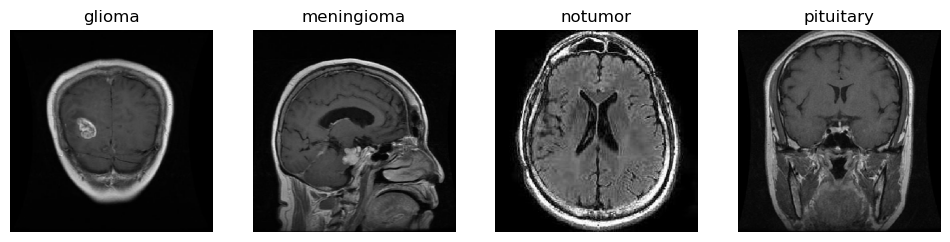

In [94]:
# Section 4: Data Preprocessing and Augmentation
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import random
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split

IMG_SIZE = 299
BATCH_SIZE = 32

# Paths
base_train_path = r'D:/Projects/Portfolio projects/Brain Tumor Dataset/Training'  
base_test_path = r'D:/Projects/Portfolio projects/Brain Tumor Dataset/Testing'    
train_path = 'split_train'         
val_path = 'split_val'             
test_path = base_test_path         

# Verify test set directory
print("Verifying test set directory structure (used for final evaluation)...")
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
for class_name in class_names:
    class_dir = os.path.join(test_path, class_name)
    if not os.path.exists(class_dir):
        raise ValueError(f"Test directory {class_dir} does not exist. Please check test_path: {test_path}")
    num_images = len(os.listdir(class_dir))
    print(f"{class_name}: {num_images} images")
    if num_images == 0:
        raise ValueError(f"Test directory {class_dir} is empty. Please check test_path: {test_path}")

# Split training data into train and validation sets
def split_train_val(base_train_path, train_path, val_path, val_split=0.1):
    if os.path.exists(train_path):
        shutil.rmtree(train_path)
    if os.path.exists(val_path):
        shutil.rmtree(val_path)
    os.makedirs(train_path, exist_ok=True)
    os.makedirs(val_path, exist_ok=True)

    for class_name in class_names:
        class_dir = os.path.join(base_train_path, class_name)
        images = os.listdir(class_dir)
        train_imgs, val_imgs = train_test_split(images, test_size=val_split, random_state=42)

        os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_path, class_name), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(class_dir, img), os.path.join(train_path, class_name, img))
        for img in val_imgs:
            shutil.copy(os.path.join(class_dir, img), os.path.join(val_path, class_name, img))

    print("New training directory structure after split (used for training):")
    for class_name in class_names:
        print(f"{class_name}: {len(os.listdir(os.path.join(train_path, class_name)))} images")
    print("\nNew validation directory structure after split (used for validation during training):")
    for class_name in class_names:
        print(f"{class_name}: {len(os.listdir(os.path.join(val_path, class_name)))} images")

split_train_val(base_train_path, train_path, val_path, val_split=0.1)

# Define data augmentation
def contrast_stretching(image):
    img_min, img_max = np.min(image), np.max(image)
    if img_max == img_min:
        return image
    stretched = (image - img_min) / (img_max - img_min)
    return stretched

def custom_preprocessing(image):
    image = contrast_stretching(image)
    image = image + np.random.normal(0, 0.05, image.shape)
    image = np.clip(image, 0, 1)
    return image

train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest',
    channel_shift_range=10.0,
    preprocessing_function=custom_preprocessing
)

test_datagen = ImageDataGenerator(
    preprocessing_function=custom_preprocessing
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Debug generators
print("Inspecting training generator...")
train_images, train_labels = next(train_generator)
print(f"Training batch shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Sample training labels: {train_labels[:5]}")
print(f"Training label sum: {np.sum(train_labels)}")

print("\nInspecting validation generator...")
val_images, val_labels = next(val_generator)
print(f"Validation batch shape: {val_images.shape}")
print(f"Validation labels shape: {val_labels.shape}")
print(f"Sample validation labels: {val_labels[:5]}")
print(f"Validation label sum: {np.sum(val_labels)}")

print("\nInspecting test generator...")
test_images, test_labels = next(test_generator)
print(f"Test batch shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")
print(f"Sample test labels: {test_labels[:5]}")
print(f"Test label sum: {np.sum(test_labels)}")

def display_sample_images():
    plt.figure(figsize=(12, 3))
    for i, tumor_type in enumerate(class_names):
        img_path = random.choice(os.listdir(os.path.join(test_path, tumor_type)))
        img = load_img(os.path.join(test_path, tumor_type, img_path), target_size=(IMG_SIZE, IMG_SIZE))
        plt.subplot(1, 4, i+1)
        plt.imshow(img)
        plt.title(tumor_type)
        plt.axis('off')
    plt.show()

display_sample_images()

# Section 5: Model Building (EfficientNetB0)

In [61]:
# Section 5: Model Building
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

# Define focal loss
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * y_true * tf.pow((1 - y_pred), gamma)
        loss = weight * cross_entropy
        return tf.reduce_mean(loss, axis=-1)
    return focal_loss_fixed

# Build model from scratch
IMG_SIZE = 299  # Define IMG_SIZE here (consistent with Section 6)
print("Building model from scratch")
base_model = EfficientNetB0(include_top=False, weights="imagenet", 
                            input_shape=(IMG_SIZE, IMG_SIZE, 3), pooling='max')
base_model.trainable = True
for layer in base_model.layers[:-60]:
    layer.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

# Compile the model with the new learning rate
model.compile(
    optimizer=Adamax(learning_rate=2e-5),  # Adjusted learning rate
    loss=focal_loss(gamma=2.0, alpha=0.25),
    metrics=['accuracy', Precision(), Recall()]
)

model.summary()

Building model from scratch


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 2,834,244 (10.81 MB)

 Non-trainable params: 1,379,811 (5.26 MB)

# Section 6: Model Training

In [63]:
# Section 6: Model Training
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import os

# Define generators with minimal augmentation
IMG_SIZE = 299
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    horizontal_flip=True  # Minimal augmentation
)

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = test_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Define minimal class weights (double weight for meningioma)
class_weight_dict = {0: 1.0, 1: 2.0, 2: 1.0, 3: 1.0}  # Class 1 is meningioma
print("Class weights:", class_weight_dict)

# Define checkpoint path and callback
checkpoint_dir = 'checkpoints_new'  # New directory for checkpoints
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5')
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,  # Save the full model
    save_freq='epoch',  # Save at the end of each epoch
    verbose=1
)

# Train the model from Epoch 1
history = model.fit(
    train_generator,
    epochs=25,  # Train for 25 epochs (1-25)
    validation_data=val_generator,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback],
    verbose=1
)

Found 4967 images belonging to 4 classes.
Found 555 images belonging to 4 classes.
Class weights: {0: 1.0, 1: 2.0, 2: 1.0, 3: 1.0}
Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2697 - loss: 0.5446 - precision_7: 0.2707 - recall_7: 0.2666
Epoch 1: saving model to checkpoints_new\model_epoch_01.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.2697 - loss: 0.5442 - precision_7: 0.2708 - recall_7: 0.2666 - val_accuracy: 0.4252 - val_loss: 0.1485 - val_precision_7: 0.4235 - val_recall_7: 0.3892
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3035 - loss: 0.4018 - precision_7: 0.3047 - recall_7: 0.2980
Epoch 2: saving model to checkpoints_new\model_epoch_02.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.3036 - loss: 0.4016 - precision_7: 0.3049 - recall_7: 0.2981 - val_accuracy: 0.5423 - val_loss: 0.1065 - val_precision_7: 0.5468 - val_recall_7: 0.5261
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3861 - loss: 0.3201 - precision_7: 0.3883 - recall_7: 0.3803
Epoch 3: saving model to checkpoints_new\model_epoch_03.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.3862 - loss: 0.3200 - precision_7: 0.3883 - recall_7: 0.3804 - val_accuracy: 0.6072 - val_loss: 0.0805 - val_precision_7: 0.6226 - val_recall_7: 0.5946
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4170 - loss: 0.2676 - precision_7: 0.4219 - recall_7: 0.4113
Epoch 4: saving model to checkpoints_new\model_epoch_04.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.4171 - loss: 0.2675 - precision_7: 0.4220 - recall_7: 0.4114 - val_accuracy: 0.6775 - val_loss: 0.0607 - val_precision_7: 0.6952 - val_recall_7: 0.6739
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4599 - loss: 0.2315 - precision_7: 0.4663 - recall_7: 0.4523
Epoch 5: saving model to checkpoints_new\model_epoch_05.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.4599 - loss: 0.2315 - precision_7: 0.4663 - recall_7: 0.4523 - val_accuracy: 0.7063 - val_loss: 0.0486 - val_precision_7: 0.7223 - val_recall_7: 0.6937
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4883 - loss: 0.2059 - precision_7: 0.4920 - recall_7: 0.4743
Epoch 6: saving model to checkpoints_new\model_epoch_06.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.4884 - loss: 0.2058 - precision_7: 0.4921 - recall_7: 0.4744 - val_accuracy: 0.7279 - val_loss: 0.0407 - val_precision_7: 0.7458 - val_recall_7: 0.7135
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5139 - loss: 0.1806 - precision_7: 0.5193 - recall_7: 0.5018
Epoch 7: saving model to checkpoints_new\model_epoch_07.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.5140 - loss: 0.1805 - precision_7: 0.5193 - recall_7: 0.5019 - val_accuracy: 0.7477 - val_loss: 0.0348 - val_precision_7: 0.7603 - val_recall_7: 0.7315
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5434 - loss: 0.1534 - precision_7: 0.5499 - recall_7: 0.5337
Epoch 8: saving model to checkpoints_new\model_epoch_08.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.5435 - loss: 0.1534 - precision_7: 0.5499 - recall_7: 0.5337 - val_accuracy: 0.7568 - val_loss: 0.0324 - val_precision_7: 0.7672 - val_recall_7: 0.7423
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5699 - loss: 0.1363 - precision_7: 0.5783 - recall_7: 0.5585
Epoch 9: saving model to checkpoints_new\model_epoch_09.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5699 - loss: 0.1363 - precision_7: 0.5783 - recall_7: 0.5585 - val_accuracy: 0.7766 - val_loss: 0.0281 - val_precision_7: 0.7958 - val_recall_7: 0.7514
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5551 - loss: 0.1377 - precision_7: 0.5630 - recall_7: 0.5423
Epoch 10: saving model to checkpoints_new\model_epoch_10.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.5552 - loss: 0.1376 - precision_7: 0.5631 - recall_7: 0.5424 - val_accuracy: 0.7748 - val_loss: 0.0261 - val_precision_7: 0.7936 - val_recall_7: 0.7550
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5840 - loss: 0.1103 - precision_7: 0.5932 - recall_7: 0.5676
Epoch 11: saving model to checkpoints_new\model_epoch_11.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.5841 - loss: 0.1103 - precision_7: 0.5933 - recall_7: 0.5677 - val_accuracy: 0.8018 - val_loss: 0.0235 - val_precision_7: 0.8194 - val_recall_7: 0.7766
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5982 - loss: 0.1003 - precision_7: 0.6162 - recall_7: 0.5841
Epoch 12: saving model to checkpoints_new\model_epoch_12.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.5982 - loss: 0.1003 - precision_7: 0.6162 - recall_7: 0.5841 - val_accuracy: 0.8126 - val_loss: 0.0208 - val_precision_7: 0.8333 - val_recall_7: 0.7838
Epoch 13/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6264 - loss: 0.0890 - precision_7: 0.6355 - recall_7: 0.6075
Epoch 13: saving model to checkpoints_new\model_epoch_13.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6263 - loss: 0.0890 - precision_7: 0.6354 - recall_7: 0.6074 - val_accuracy: 0.8126 - val_loss: 0.0193 - val_precision_7: 0.8363 - val_recall_7: 0.7730
Epoch 14/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6295 - loss: 0.0821 - precision_7: 0.6458 - recall_7: 0.6105
Epoch 14: saving model to checkpoints_new\model_epoch_14.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.6296 - loss: 0.0821 - precision_7: 0.6458 - recall_7: 0.6105 - val_accuracy: 0.8126 - val_loss: 0.0171 - val_precision_7: 0.8480 - val_recall_7: 0.7838
Epoch 15/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6310 - loss: 0.0753 - precision_7: 0.6485 - recall_7: 0.6128
Epoch 15: saving model to checkpoints_new\model_epoch_15.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6310 - loss: 0.0753 - precision_7: 0.6485 - recall_7: 0.6128 - val_accuracy: 0.8216 - val_loss: 0.0159 - val_precision_7: 0.8529 - val_recall_7: 0.7838
Epoch 16/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6351 - loss: 0.0722 - precision_7: 0.6560 - recall_7: 0.6147
Epoch 16: saving model to checkpoints_new\model_epoch_16.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6351 - loss: 0.0721 - precision_7: 0.6560 - recall_7: 0.6147 - val_accuracy: 0.8180 - val_loss: 0.0156 - val_precision_7: 0.8546 - val_recall_7: 0.7730
Epoch 17/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6476 - loss: 0.0664 - precision_7: 0.6654 - recall_7: 0.6231
Epoch 17: saving model to checkpoints_new\model_epoch_17.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.6476 - loss: 0.0664 - precision_7: 0.6654 - recall_7: 0.6230 - val_accuracy: 0.8324 - val_loss: 0.0150 - val_precision_7: 0.8606 - val_recall_7: 0.7784
Epoch 18/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6569 - loss: 0.0609 - precision_7: 0.6752 - recall_7: 0.6257
Epoch 18: saving model to checkpoints_new\model_epoch_18.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6570 - loss: 0.0609 - precision_7: 0.6753 - recall_7: 0.6258 - val_accuracy: 0.8396 - val_loss: 0.0144 - val_precision_7: 0.8683 - val_recall_7: 0.7838
Epoch 19/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6623 - loss: 0.0575 - precision_7: 0.6859 - recall_7: 0.6349
Epoch 19: saving model to checkpoints_new\model_epoch_19.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.6623 - loss: 0.0575 - precision_7: 0.6859 - recall_7: 0.6349 - val_accuracy: 0.8378 - val_loss: 0.0141 - val_precision_7: 0.8707 - val_recall_7: 0.7766
Epoch 20/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6732 - loss: 0.0541 - precision_7: 0.7024 - recall_7: 0.6408
Epoch 20: saving model to checkpoints_new\model_epoch_20.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 191s 1s/step - accuracy: 0.6731 - loss: 0.0541 - precision_7: 0.7023 - recall_7: 0.6407 - val_accuracy: 0.8360 - val_loss: 0.0139 - val_precision_7: 0.8820 - val_recall_7: 0.7676
Epoch 21/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6819 - loss: 0.0487 - precision_7: 0.7125 - recall_7: 0.6542
Epoch 21: saving model to checkpoints_new\model_epoch_21.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6819 - loss: 0.0487 - precision_7: 0.7125 - recall_7: 0.6542 - val_accuracy: 0.8432 - val_loss: 0.0137 - val_precision_7: 0.8866 - val_recall_7: 0.7604
Epoch 22/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6797 - loss: 0.0500 - precision_7: 0.7109 - recall_7: 0.6442
Epoch 22: saving model to checkpoints_new\model_epoch_22.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6797 - loss: 0.0500 - precision_7: 0.7109 - recall_7: 0.6443 - val_accuracy: 0.8468 - val_loss: 0.0135 - val_precision_7: 0.8985 - val_recall_7: 0.7495
Epoch 23/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6899 - loss: 0.0473 - precision_7: 0.7142 - recall_7: 0.6521
Epoch 23: saving model to checkpoints_new\model_epoch_23.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.6899 - loss: 0.0473 - precision_7: 0.7142 - recall_7: 0.6521 - val_accuracy: 0.8505 - val_loss: 0.0133 - val_precision_7: 0.9031 - val_recall_7: 0.7387
Epoch 24/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6804 - loss: 0.0454 - precision_7: 0.7164 - recall_7: 0.6444
Epoch 24: saving model to checkpoints_new\model_epoch_24.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.6804 - loss: 0.0454 - precision_7: 0.7165 - recall_7: 0.6445 - val_accuracy: 0.8432 - val_loss: 0.0133 - val_precision_7: 0.9025 - val_recall_7: 0.7171
Epoch 25/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6920 - loss: 0.0416 - precision_7: 0.7309 - recall_7: 0.6487
Epoch 25: saving model to checkpoints_new\model_epoch_25.h5


156/156 ━━━━━━━━━━━━━━━━━━━━ 200s 1s/step - accuracy: 0.6921 - loss: 0.0416 - precision_7: 0.7308 - recall_7: 0.6487 - val_accuracy: 0.8450 - val_loss: 0.0131 - val_precision_7: 0.9053 - val_recall_7: 0.7063


# Section 7: Plot Training Metrics

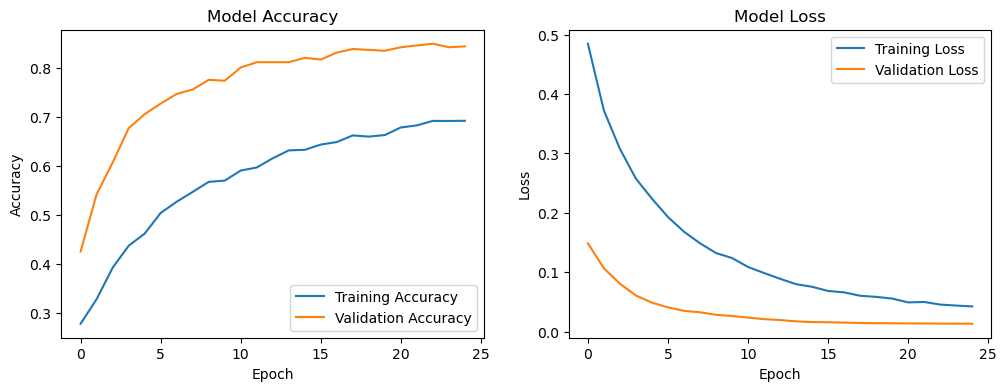

In [65]:
# Section 7: Plot Training Metrics
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

plot_metrics(history)

# Section 8: Model Evaluation and Confusion Matrix

Found 1205 images belonging to 4 classes.
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 783ms/step - accuracy: 0.7356 - loss: 0.0187 - precision_7: 0.7969 - recall_7: 0.5980

Test Accuracy: 0.8108
Test Precision: 0.8786
Test Recall: 0.6788
38/38 ━━━━━━━━━━━━━━━━━━━━ 36s 874ms/step


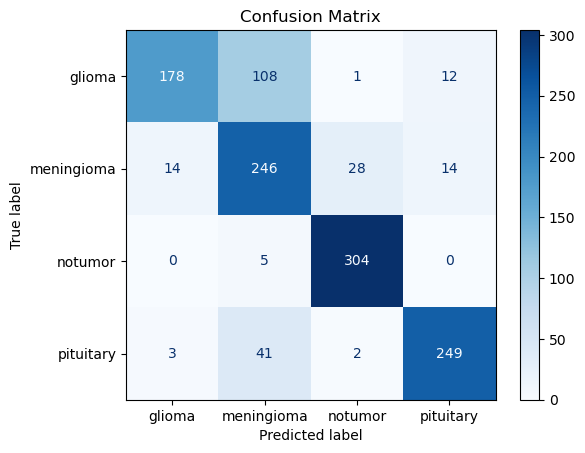

In [67]:
# Section 8: Model Evaluation and Confusion Matrix
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

# Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Section 9: Random Image Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


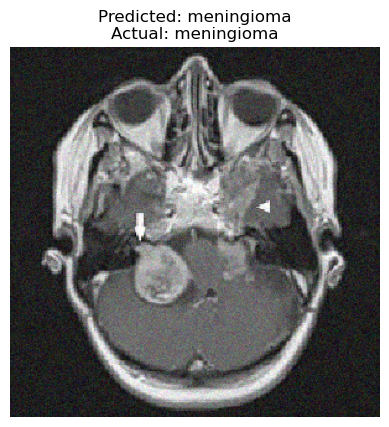

Prediction confidence: 0.4347


In [90]:
# Section 9: Random Image Prediction
def contrast_stretching(image):
    img_min, img_max = np.min(image), np.max(image)
    if img_max == img_min:
        return image
    stretched = (image - img_min) / (img_max - img_min)
    return stretched

def custom_preprocessing(image):
    image = contrast_stretching(image)
    image = image + np.random.normal(0, 0.05, image.shape)
    image = np.clip(image, 0, 1)
    return image

def predict_random_image():
    # Randomly select a class and image from the test directory
    random_class = random.choice(class_names)
    class_path = os.path.join(test_path, random_class)
    random_img_name = random.choice(os.listdir(class_path))
    random_img_path = os.path.join(class_path, random_img_name)
    
    # Load and preprocess the image
    img = load_img(random_img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    img = custom_preprocessing(img)  # Apply your preprocessing
    img_array = np.expand_dims(img, axis=0)
    
    # Predict
    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]
    actual_class = random_class  # True label from directory
    
    # Display
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nActual: {actual_class}")
    plt.axis('off')
    plt.show()
    
    print(f"Prediction confidence: {prediction[0][np.argmax(prediction)]:.4f}")

# Test a random prediction
predict_random_image()